In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm, randint, uniform
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [52]:
def load_data():
    data = load_breast_cancer()
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = pd.Series(data.target)
    return X, y

In [53]:
#func. to do some Exploratory data analysis like plotting the distribution of features, Correlation heatmap, distribution plots of features, target variable distribution
def eda(X, y):
    print("Dataset Information:")
    print(X.info())

    print("\nSummary Statistics:")
    print(X.describe())

    print("\nClass Distribution:")
    print(y.value_counts())

    X.hist(bins=20, figsize=(20, 15))
    plt.show()

    plt.figure(figsize=(16, 12))
    sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.show()

    sns.countplot(x=y)
    plt.show()

    X_scaled = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

    plt.figure(figsize=(20, 15))
    for i, col in enumerate(X.columns):
        plt.subplot(6, 5, i+1)
        sns.kdeplot(X_scaled[col], fill=True)
        plt.title(col)
    plt.tight_layout()
    plt.show()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoot

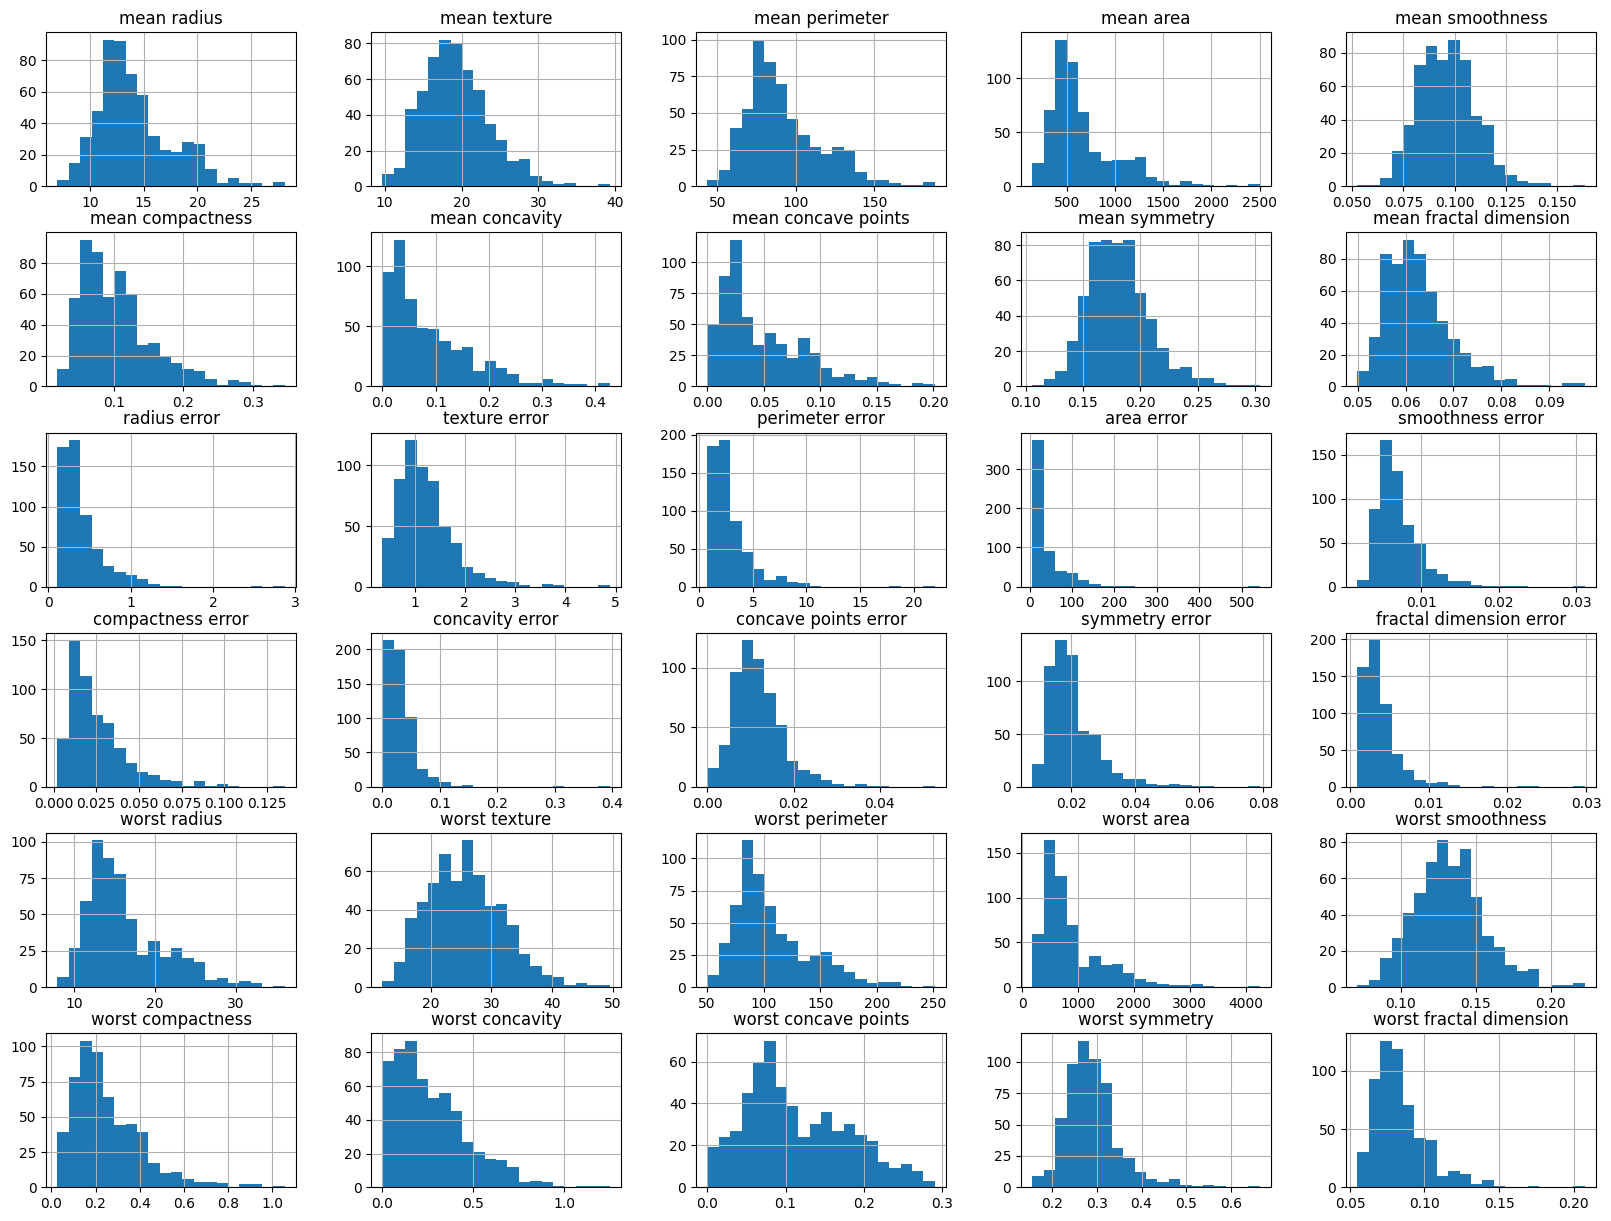

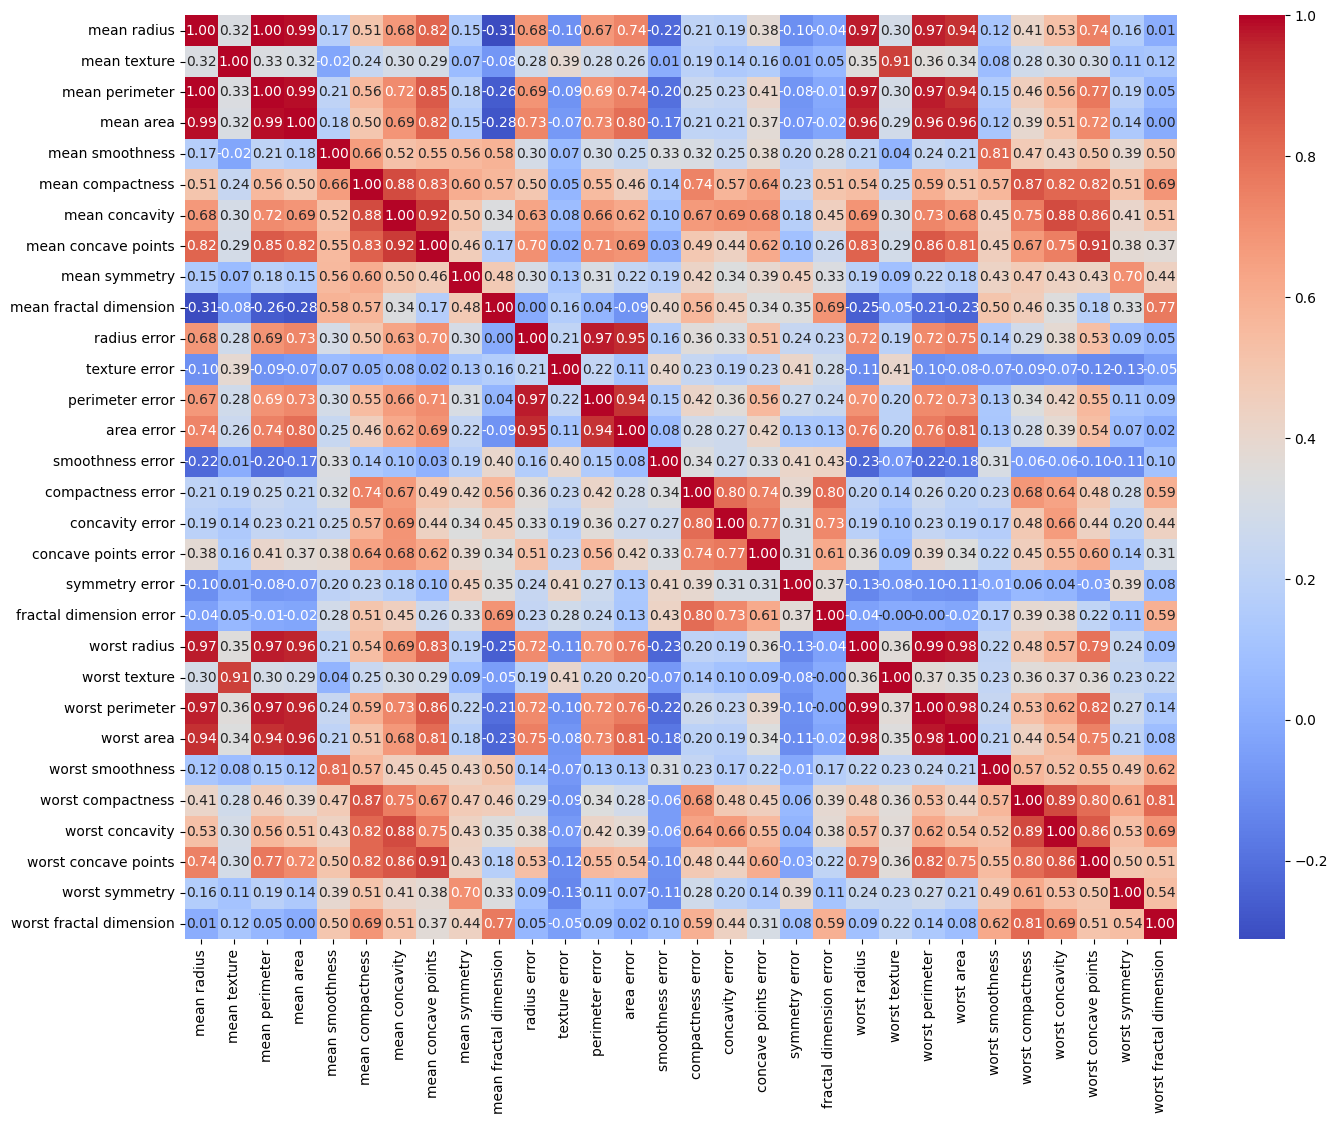

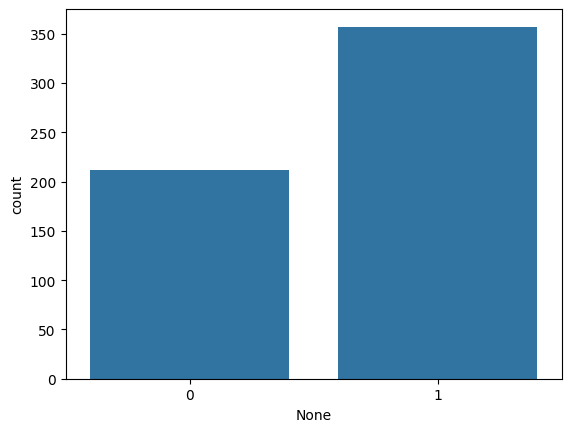

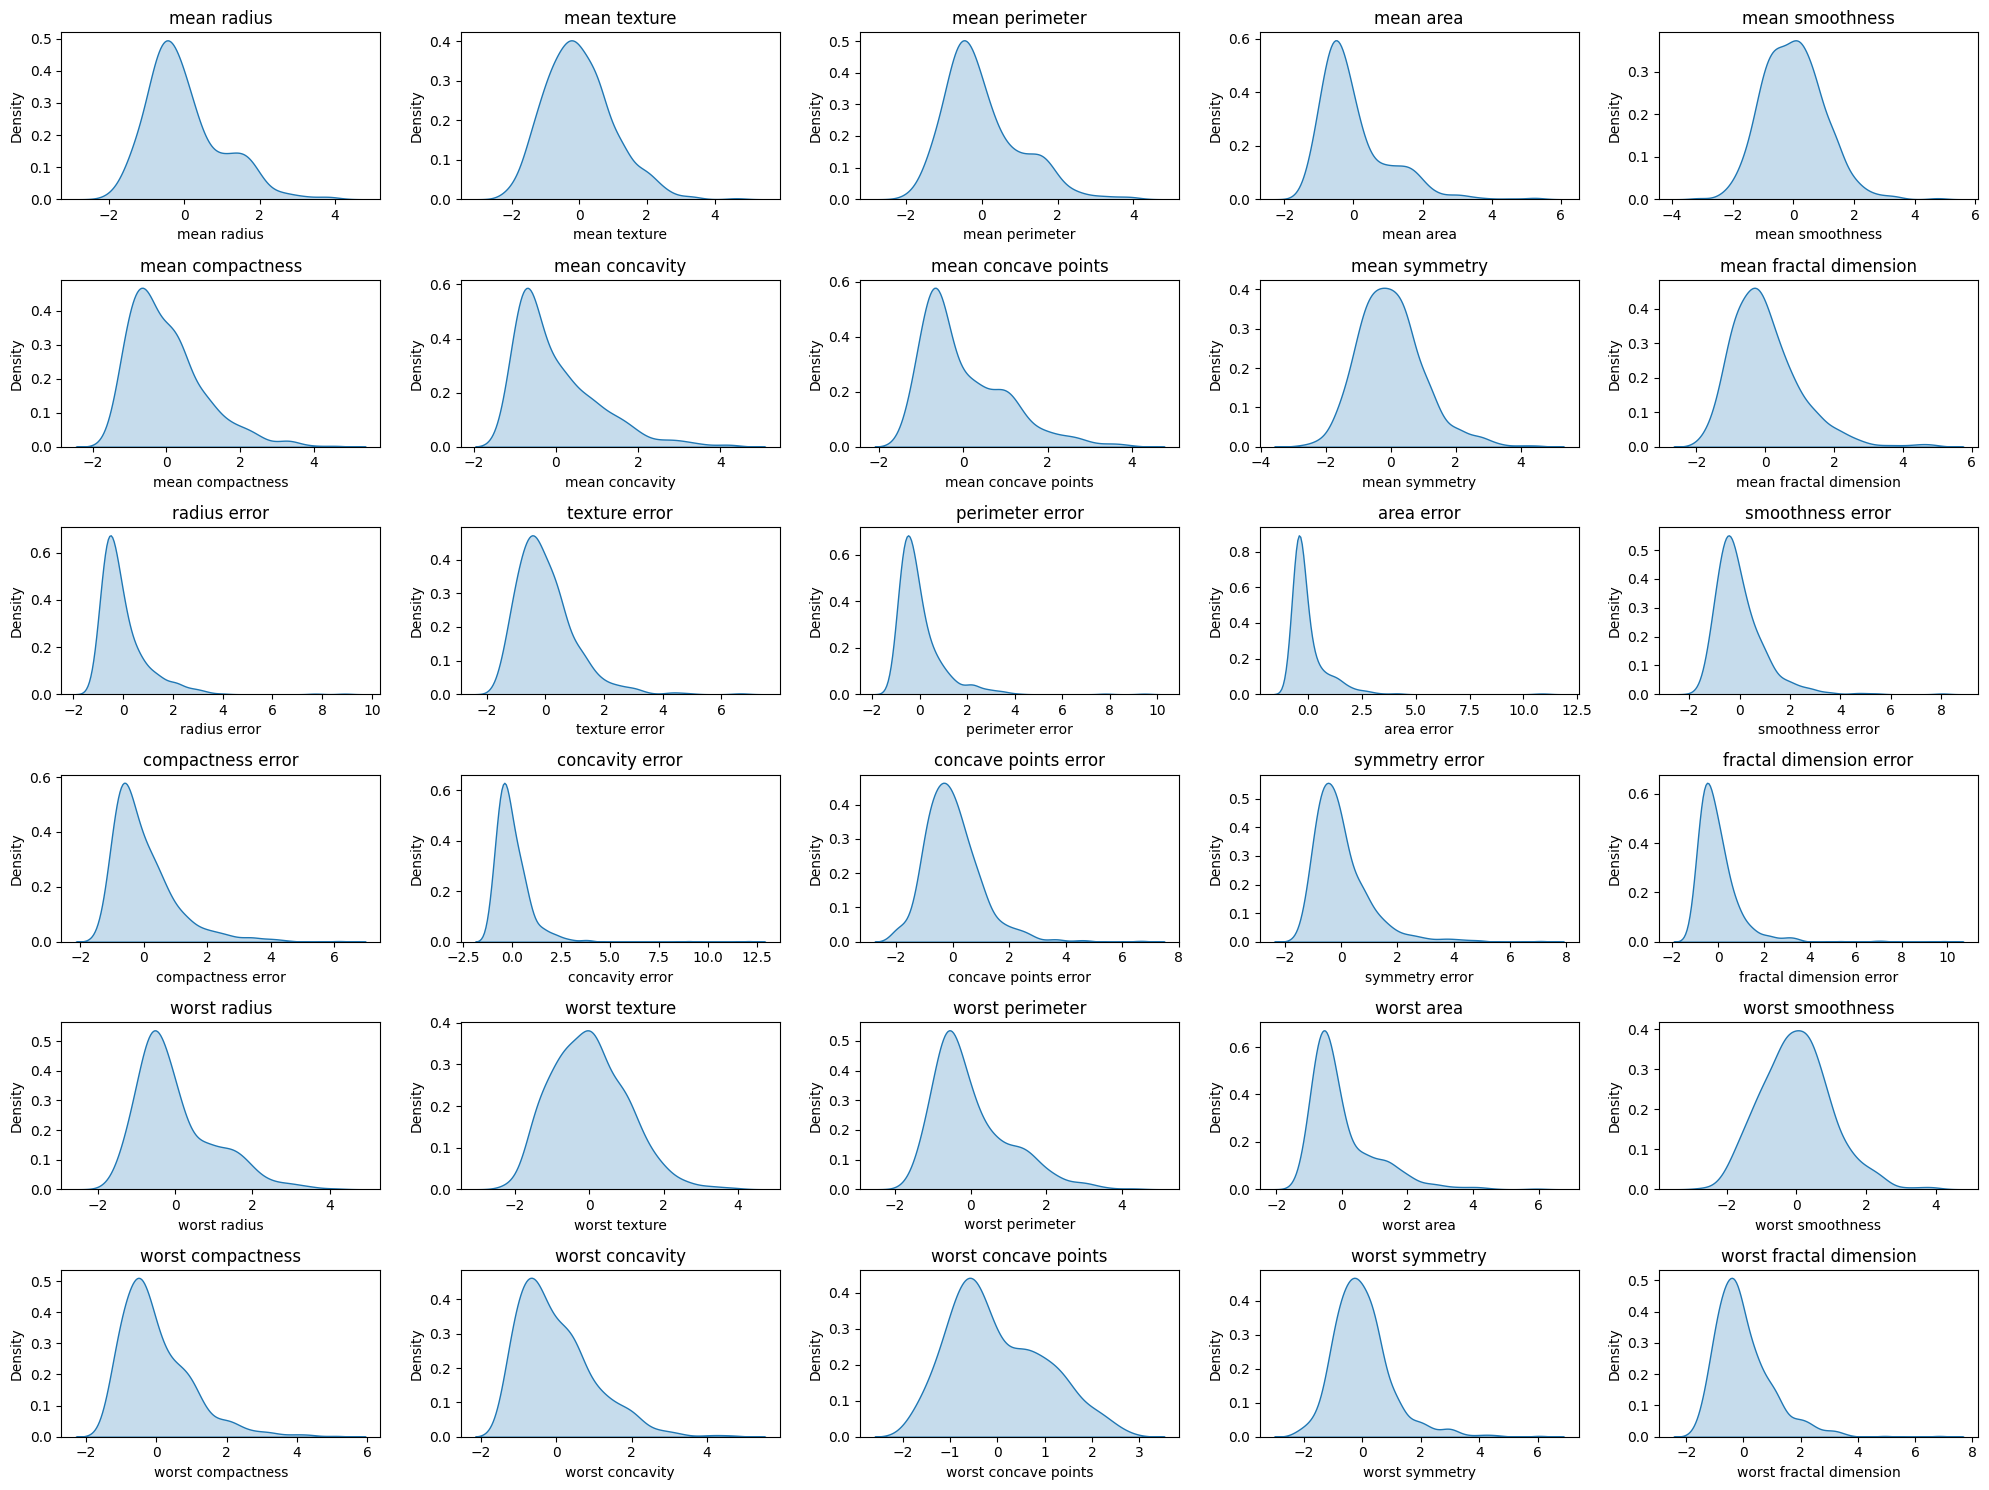

In [54]:
X, y = load_data()
eda(X, y)

In [55]:
#deefining the RandomForestClassifier model
def create_model(params):
    model = RandomForestClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        min_samples_leaf=int(params['min_samples_leaf']),
        max_features=params['max_features']
    )
    return model

In [56]:
#func. to implement the Tree-structured Parzen Estimator (TPE)
class TPE:
    def __init__(self, objective_function, parameter_space, n_iterations=50, n_initial_points=10, early_stopping_rounds=10):
        self.objective_function = objective_function
        self.parameter_space = parameter_space
        self.n_iterations = n_iterations
        self.n_initial_points = n_initial_points
        self.early_stopping_rounds = early_stopping_rounds
        self.results = []
        self.best_score = -np.inf
        self.no_improvement_count = 0

    def suggest(self):
        if len(self.results) < self.n_initial_points:
            return {key: val.rvs() for key, val in self.parameter_space.items()}
        else:
            sorted_results = sorted(self.results, key=lambda x: x['score'])
            l = int(0.2 * len(sorted_results))
            g_results = sorted_results[:l]
            b_results = sorted_results[l:]

            def l_pdf(x):
                return np.mean([norm(loc=r['params'][key], scale=1).pdf(x) for r in g_results])

            def g_pdf(x):
                return np.mean([norm(loc=r['params'][key], scale=1).pdf(x) for r in b_results])

            new_params = {}
            for key in self.parameter_space:
                values = np.linspace(self.parameter_space[key].a, self.parameter_space[key].b, 100)
                pdf_ratios = [l_pdf(val) / g_pdf(val) if g_pdf(val) > 0 else 0 for val in values]  # Handle divide by zero
                new_params[key] = values[np.argmax(pdf_ratios)]
            return new_params

    def optimize(self):
        for i in range(self.n_iterations):
            params = self.suggest()
            score = self.objective_function(params)
            self.results.append({'params': params, 'score': score})
            if score > self.best_score:
                self.best_score = score
                self.no_improvement_count = 0
            else:
                self.no_improvement_count += 1

            if self.no_improvement_count >= self.early_stopping_rounds:
                print(f"Early stopping at iteration {i}")
                break

        best_result = sorted(self.results, key=lambda x: x['score'], reverse=True)[0]
        return best_result

In [57]:
#the objective function
def objective_function(params):
    model = create_model(params)
    X, y = load_data()
    cv = StratifiedKFold(n_splits=5)
    scores = []
    for train_idx, valid_idx in cv.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_valid)[:, 1]
        scores.append(roc_auc_score(y_valid, y_pred))
    return np.mean(scores)

#the parameter space with probability distributions
parameter_space = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(5, 100),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': stats.uniform(0.1, 0.9)  # Ensure range is (0.1, 1.0) for float values
}


In [58]:
#running the TPE optimization
tpe = TPE(objective_function, parameter_space, n_iterations=50, n_initial_points=10, early_stopping_rounds=10)
best_params = tpe.optimize()

Early stopping at iteration 17


In [59]:
#now ttraining the final model with the best parameters
final_model = create_model(best_params['params'])
X, y = load_data()

In [60]:
final_model.fit(X, y)

#evaluating the final model with ROC AUC scores and some additional performance metrics
y_pred = final_model.predict_proba(X)[:, 1]
roc_auc = roc_auc_score(y, y_pred)
print(f'Best Parameters: {best_params["params"]}')
print(f'Final Model ROC AUC: {roc_auc}')

y_pred_class = final_model.predict(X)
print("\nClassification Report:")
print(classification_report(y, y_pred_class))
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred_class))

Best Parameters: {'n_estimators': 185, 'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 0.13138937768444633}
Final Model ROC AUC: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       212
           1       0.99      1.00      1.00       357

    accuracy                           1.00       569
   macro avg       1.00      1.00      1.00       569
weighted avg       1.00      1.00      1.00       569


Confusion Matrix:
[[210   2]
 [  0 357]]


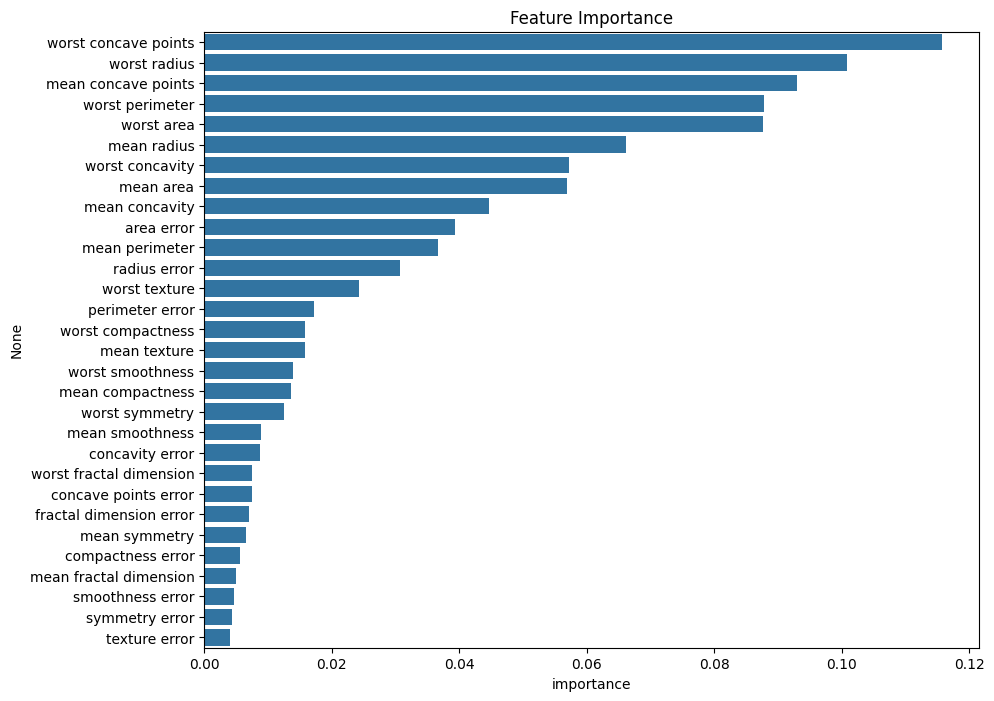

In [61]:
#visualizing the feature importance
feature_importances = pd.DataFrame(final_model.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.importance, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()

In [62]:
#comparing with a random search model
def random_search(n_iterations=50):
    best_score = -np.inf
    best_params = None
    for _ in range(n_iterations):
        params = {key: val.rvs() for key, val in parameter_space.items()}
        score = objective_function(params)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params, best_score

random_params, random_score = random_search()
print(f'Random Search Best Parameters: {random_params}')
print(f'Random Search Best ROC AUC: {random_score}')



Random Search Best Parameters: {'n_estimators': 151, 'max_depth': 43, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 0.14049053191698205}
Random Search Best ROC AUC: 0.9919160527332818


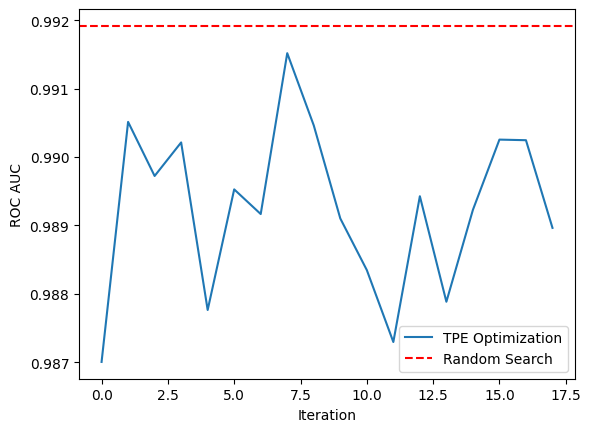

In [63]:
#plotting the learning rate distribution curves
scores = [res['score'] for res in tpe.results]
plt.plot(scores, label='TPE Optimization')
plt.axhline(random_score, color='r', linestyle='--', label='Random Search')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

In [64]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')